In [3]:
import numpy as np
import pandas as pd
import os

import nltk
from nltk.corpus import machado, mac_morpho
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer

import string
from string import punctuation
from pprint import pprint

from collections import defaultdict
from collections import OrderedDict
from collections import Counter

from collections import Counter
from IPython.display import clear_output
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from textblob import TextBlob

import io
import math
import string
import nltk 

from wordcloud import WordCloud
nltk.download('stopwords')
import os
import PyPDF2
from PyPDF2 import PdfFileReader
import tika
from tika import parser
from tika import config
from gensim import corpora, models, similarities

from math import log
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
%pylab inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria.gontijo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Populating the interactive namespace from numpy and matplotlib


C:\Users\maria.gontijo\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Exercício 1
A partir de um corpus à sua escolha, estime um modelo de assuntos baseado no Modelo LSI. Uma vez calculado o modelo, defina um conjunto de documentos relevantes (${\cal R}$) para um assunto, como os $n$ documentos que contiverem em sua representação LSI, os maiores coeficientes para o assunto escolhido. Construa uma consulta $q$, com as dez palavras mais importantes do assunto escolhido.

In [4]:
def read_pdf(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True): 
        interpreter.process_page(page)
    text = retstr.getvalue()
    text = " ".join(text.replace(u"\xa0", " ").strip().split())  
    fp.close()
    device.close()
    retstr.close()
    return text

In [5]:
files = os.listdir(r'C:\Users\maria.gontijo\Documents\contratos_pdfminer2')

docs=[]
for file in files:
    doc=read_pdf("contratos_pdfminer2/{}".format(file))
    docs.append(doc)

In [6]:
textos=docs
swu = stopwords.words('portuguese') + list (string.punctuation)
stemmer = PortugueseStemmer()

textos_limpos = []
for texto in textos:
    tlimpo = [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
    textos_limpos.append(tlimpo)

In [7]:
dicionario = corpora.Dictionary(textos_limpos)
corpus = [dicionario.doc2bow(text) for text in textos_limpos]

In [8]:
# Modelo TFIDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Modelo LSI
lsi = models.LsiModel(corpus_tfidf, id2word=dicionario, num_topics=10)
corpus_lsi = lsi[corpus_tfidf]

In [9]:
data = {i: OrderedDict(lsi.show_topic(i,10)) for i in range(10)}
df = pd.DataFrame(data)
print(df.shape)
df = df.fillna(0).T

(55, 10)


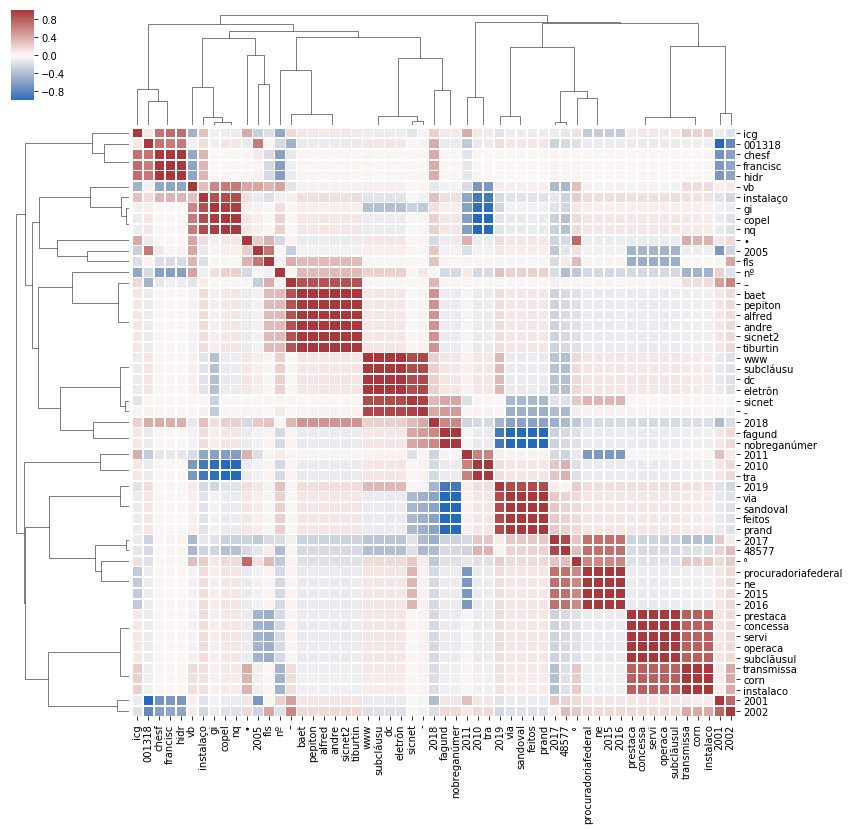

In [10]:
sns.clustermap(df.corr(), center=0, cmap="vlag", metric='cosine',
               linewidths=.75, figsize=(13, 13))

In [11]:
lsi.show_topics(10,10)

[(0,
  '-0.670*"–" + -0.203*"2018" + -0.189*"andre" + -0.137*"fls" + -0.127*"tiburtin" + -0.127*"nº" + -0.127*"alfred" + -0.127*"baet" + -0.126*"sicnet2" + -0.126*"pepiton"'),
 (1,
  '-0.247*"2011" + -0.199*"transmissa" + -0.190*"corn" + -0.160*"fls" + -0.156*"2005" + -0.152*"icg" + -0.149*"instalaco" + -0.146*"°" + -0.135*"vb" + -0.135*"•"'),
 (2,
  '-0.370*"corn" + -0.356*"transmissa" + -0.292*"instalaco" + 0.266*"fls" + -0.227*"servi" + 0.191*"2005" + -0.157*"concessa" + -0.128*"prestaca" + -0.123*"operaca" + -0.117*"subclãusul"'),
 (3,
  '0.365*"fls" + 0.281*"–" + 0.192*"2005" + 0.176*"corn" + -0.171*"nº" + -0.166*"2011" + 0.163*"transmissa" + -0.153*"2017" + 0.139*"instalaco" + 0.139*"2002"'),
 (4,
  '0.341*"2011" + -0.339*"2017" + -0.249*"48577" + 0.206*"icg" + -0.163*"sicnet" + -0.142*"2016" + -0.128*"2015" + -0.124*"ne" + -0.119*"°" + -0.116*"procuradoriafederal"'),
 (5,
  '0.390*"–" + -0.368*"2005" + 0.189*"2001" + 0.177*"2002" + -0.166*"2018" + -0.156*"hidr" + 0.142*"2011" + 

In [12]:
data = {'doc%s'%i: dict(doc) for i,doc in enumerate(corpus_lsi[:10])}
dfdoc = pd.DataFrame(data)
dfdoc = dfdoc.fillna(0)
dfdoc.head()

,doc0,doc1,doc2,doc3,doc4,doc5,doc6,doc7,doc8,doc9
0,-0.459054,-0.116054,-0.052391,-0.028516,-0.058921,-0.490159,-0.505908,-0.101532,-0.083379,-0.057837
1,-0.070923,-0.249628,-0.269667,-0.433482,-0.142496,0.084803,-0.054493,-0.230356,-0.400367,-0.213973
2,0.212605,0.274178,0.040586,-0.692276,0.014278,-0.075861,0.206726,0.251824,0.137528,0.010869
3,0.359219,0.269241,-0.147111,0.296966,-0.159219,-0.091571,0.363203,0.251165,-0.233672,-0.107640
4,-0.103885,-0.034458,0.126304,-0.003035,-0.250878,0.013667,-0.108235,-0.030581,0.299069,0.061588


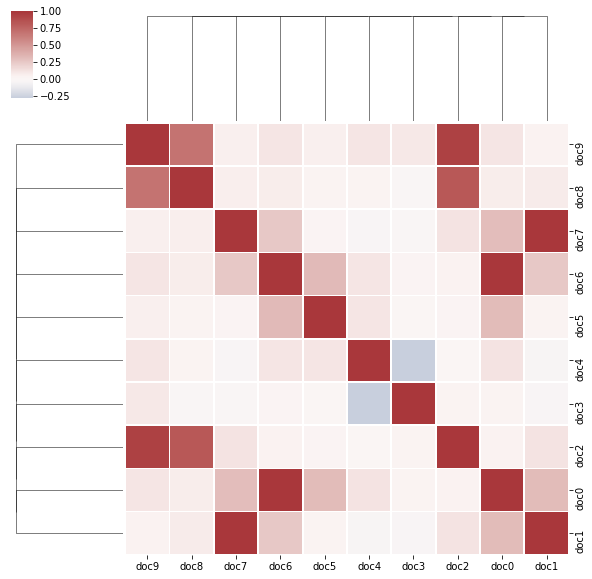

In [13]:
sns.clustermap(dfdoc.corr(), center=0, cmap="vlag", metric='hamming',
               linewidths=.75, figsize=(10, 10));

In [14]:
dfdoc.T.describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-0.195375,-0.198058,0.038046,0.080058,-0.003044,0.046695,0.030421,0.002109,-0.065709,-0.010904
std,0.201748,0.158222,0.282437,0.245446,0.147896,0.201102,0.130539,0.077740,0.124822,0.074023
min,-0.505908,-0.433482,-0.692276,-0.233672,-0.250878,-0.282925,-0.051325,-0.080650,-0.237755,-0.147539
25%,-0.373304,-0.264657,0.011721,-0.137244,-0.086528,-0.019830,-0.030665,-0.057408,-0.171507,-0.041770
50%,-0.092455,-0.222164,0.089057,0.079797,-0.016808,0.074959,-0.004522,-0.014319,-0.057327,-0.012317
75%,-0.058108,-0.088816,0.211135,0.290035,0.049607,0.170428,0.020383,0.040985,-0.004762,0.025957
max,-0.028516,0.084803,0.274178,0.363203,0.299069,0.303758,0.394101,0.169158,0.122452,0.121063


In [15]:
topico = 5
lsi.show_topic(topico,10)

[('–', 0.3898678771587401),
 ('2005', -0.3681296656300138),
 ('2001', 0.18901367320272355),
 ('2002', 0.17711456106057027),
 ('2018', -0.16583828430018355),
 ('hidr', -0.15551810607661723),
 ('2011', 0.14221165543459913),
 ('francisc', -0.140088888535377),
 ('chesf', -0.13149232534130018),
 ('001318', -0.1307359556279306)]

In [16]:
lista = []
for i,texto in enumerate(corpus_lsi):
    lista.append((texto[topico][1],i))

R_relevantes = []
n_relevantes = 25
for i in sorted(lista,reverse = True)[:n_relevantes]:
    R_relevantes.append(i[1])

In [17]:
R_relevantes = set(R_relevantes)
print(R_relevantes)

{0, 128, 2, 6, 8, 9, 14, 17, 18, 22, 162, 171, 173, 55, 184, 192, 193, 194, 195, 197, 198, 199, 79, 84, 89}


In [18]:
t_relevantes = 10
q_consulta = []
for t in lsi.show_topic(topico,10):
    q_consulta.append(t[0])

In [19]:
print(q_consulta)

['–', '2005', '2001', '2002', '2018', 'hidr', '2011', 'francisc', 'chesf', '001318']


### Exercício 2
Reutilizando os índices invertidos construídos em exercícios anteriores(Booleano, e TFIDF), calcule a precisão e revocação com a consulta $q$ e o conjunto relevante ${\cal R}$ definidos no exercício anterior.

Inicialmente vamos gerar o índice invertido do nosso corpus:

In [20]:
indice = defaultdict(lambda:set([]))
for tid,t in enumerate(textos_limpos):
    for term in t:
        indice[term].add(tid)

In [21]:
def busca_booleana(search, indice):

    resultado = indice[search[0]]
    for token in search[1:]:
            resultado = resultado | indice[token]
    
    return resultado

In [22]:
resp_boo = busca_booleana(q_consulta,indice)
resp_boo = set(resp_boo)
print(resp_boo)

{0, 1, 2, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 76, 77, 78, 79, 81, 82, 83, 84, 85, 87, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 122, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 144, 145, 146, 148, 149, 150, 152, 154, 155, 156, 158, 160, 161, 162, 163, 164, 168, 169, 170, 171, 173, 175, 176, 177, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}


In [23]:
T = nltk.TextCollection(textos_limpos)

tfidf_matrix = np.zeros((len(textos_limpos),len(q_consulta)))

for j, termo in enumerate(q_consulta):
    for i, texto in enumerate(textos_limpos):
        tfidf_matrix[i,j] = T.tf_idf(termo,texto)
        
Mtfidf_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in tfidf_matrix])

In [24]:
def ordem(q,MN):
    return [np.dot(q,r) for r in MN]

In [25]:
vetor_tfidf = np.array([T.tf_idf(w,q_consulta) for w in q_consulta])
vetor_tfidf /= norm(vetor_tfidf)
resp_tfidf = ordem(vetor_tfidf,Mtfidf_Norm)

vtfidf = filter(lambda x : x[0]!=0.0, zip(resp_tfidf,range(len(textos_limpos))))

temp_tfidf = sorted(vtfidf, reverse=True)

trunc = 0.3
resp_tfidf = []
for i in temp_tfidf:
    if i[0]>= trunc:
        resp_tfidf.append(i[1])

In [26]:
resp_tfidf = set(resp_tfidf)
print(resp_tfidf)

{0, 1, 129, 128, 2, 132, 6, 7, 136, 8, 137, 139, 134, 13, 14, 142, 21, 22, 149, 62, 27, 155, 28, 30, 31, 162, 35, 36, 168, 42, 43, 46, 175, 51, 52, 184, 185, 186, 59, 60, 61, 189, 188, 187, 65, 66, 194, 195, 193, 191, 190, 72, 192, 78, 79, 84, 85, 89, 91, 92, 96, 106, 107, 108, 111, 112, 114, 115, 118, 120, 123, 124, 125}


In [27]:
def RevPre(parcial,geral):
    
    rev = len(parcial & geral)/len(geral)
    pre = len(parcial & geral)/len(parcial)
    
    print('Revocação = ' + str(rev))
    print('Precisão = ' + str(pre))

In [28]:
print('Resultados para a busca booleana:')
RevPre(resp_boo,R_relevantes)
print('\n')
print('Resultados para a busca por tf_idf:')
RevPre(resp_tfidf,R_relevantes)

Resultados para a busca booleana:
Revocação = 0.96
Precisão = 0.16216216216216217


Resultados para a busca por tf_idf:
Revocação = 0.64
Precisão = 0.2191780821917808


### Exercício 3
Usando as definições de probabilidade de relevância apresentadas no capítulo 11 do Livro, construa uma função de recuperação probabilística usando o log da razão de Odds como RSV (retrieval status value). Calcule revocação e precisão para consulta $q$ e conjunto relevante ${\cal R}$. Compare a probabilidade $p_t=P(x_t=1|R=1,q)$, com a o rankeamento de importância das palavras que compõem o assunto escolhido.

In [29]:
def busca_probabilistica(query, indice, relevantes, n_docs = 246):
    
    # query = consulta a ser realizada
    # indice = indice invertido
    # relevantes = conjunto de documentos atualmente considerados relevantes
    # N_docs = número de documentos presente no corpus
    
    query_tok = query
    
    c_t = []
    soma = len(relevantes)
    n = n_docs
    
    for termo in query_tok:
        soma_aux = len(indice[termo] & relevantes)
        df = len(indice[termo])
        
        up = soma_aux/(soma - soma_aux + 0.5)
        down =(df - soma_aux)/(n - df - soma + soma_aux - 0.5)
        
        c_t.append(np.log(up/down))
    
    RSV_d = []
    for doc in range(n):
        rsv = 0
        for pos,termo in enumerate(query_tok):
            if doc in indice[termo]:
                rsv += c_t[pos]
        RSV_d.append((rsv,doc))
        
    resultado = sorted(RSV_d,reverse=True)
    
    return resultado

In [30]:
temp_prob = busca_probabilistica(q_consulta,indice,R_relevantes)
print(temp_prob[:10])

[(6.384866953963514, 6), (6.384866953963514, 0), (6.1484781758992835, 192), (6.1484781758992835, 184), (6.1484781758992835, 162), (5.27272955967951, 85), (4.908230168649823, 31), (4.730859481016022, 125), (4.685173632386713, 195), (4.448784854322482, 194)]


C:\Users\maria.gontijo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [31]:
trunc = 1
resp_prob = []
for i in temp_prob:
    if i[0] >= trunc:
        resp_prob.append(i[1])
        
resp_prob = set(resp_prob)
print(resp_prob)

{0, 128, 2, 132, 4, 6, 134, 8, 136, 137, 139, 14, 142, 149, 22, 28, 31, 162, 36, 168, 43, 171, 173, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197, 198, 199, 72, 78, 79, 84, 85, 89, 92, 108, 115, 123, 124, 125}


In [32]:
RevPre(resp_prob,R_relevantes)

Revocação = 0.84
Precisão = 0.42857142857142855


In [33]:
p_termo = []
S = len(R_relevantes)
for termo in q_consulta:
    s = len(indice[termo] & R_relevantes)
    p_termo.append((termo,s/S))

In [34]:
print(p_termo)
print('\n')
print(lsi.show_topic(topico,10))

[('–', 0.52), ('2005', 0.32), ('2001', 0.32), ('2002', 0.32), ('2018', 0.08), ('hidr', 0.0), ('2011', 0.32), ('francisc', 0.08), ('chesf', 0.12), ('001318', 0.0)]


[('–', 0.3898678771587401), ('2005', -0.3681296656300138), ('2001', 0.18901367320272355), ('2002', 0.17711456106057027), ('2018', -0.16583828430018355), ('hidr', -0.15551810607661723), ('2011', 0.14221165543459913), ('francisc', -0.140088888535377), ('chesf', -0.13149232534130018), ('001318', -0.1307359556279306)]


### Exercício 4: Indexação Semântica Latente.
Repita o exercício 3 agora usando o modelo Okapi BM25 para o rankeamento. Calcule precisão e revocação.

Ainda da aula 11, temos que:

O Okapi BM25 é um modelo probabilístico que incorpora frequência dos termos (ou seja, não é binário) e normalização de comprimento. Para buscas de texto completo modernas, um modelo deve atentar à frequência de termos e ao comprimento do documento. BestMatch25 (também conhecido como BM25 ou Okapi) é sensível a estas grandezas. O BM25 é um dos modelos de recuperação mais robustos e amplamente utilizados.

In [35]:
def busca_okapi_bm25(query, indice, corpus):
    
    # query = consulta a ser realizada
    # indice = indice invertido
    
    query_tok = query 
    
    N = len(corpus)
    
    L = []
    for texto in corpus:
        L.append(len(texto))
        
    L_med = sum(L)/N
    k1 = 1.2
    b = 0.75
    
    RSVd = []
    for doc in range(N):
        rsv = 0
        
        for termo in query_tok:
            if doc in indice[termo]:
                tf = 1 
            df = len(indice[termo])
        rsv += np.log(N/df)*((k1 + 1)*tf)/(k1*(1 - b + (b*(L[doc]/L_med))) + tf)
        
        RSVd.append((rsv,doc))
        
    resultado = sorted(RSVd,reverse=True)
    
    return resultado

In [36]:
temp_okapi = busca_okapi_bm25(q_consulta,indice, textos_limpos)
print(temp_okapi[:10])

[(5.01411439306123, 80), (4.520029859717209, 160), (4.015235399751334, 34), (3.622156337010022, 198), (3.6120383179317974, 191), (3.6063067042800303, 197), (3.55654085605134, 196), (3.5107573268267096, 185), (3.508622175171151, 186), (3.498637972120564, 162)]


In [37]:
trunc_okapi = 1
resp_okapi = []
for i in temp_okapi:
    if i[0] >= trunc_okapi:
        resp_okapi.append(i[1])
        
resp_okapi = set(resp_okapi)
print(resp_prob)

{0, 128, 2, 132, 4, 6, 134, 8, 136, 137, 139, 14, 142, 149, 22, 28, 31, 162, 36, 168, 43, 171, 173, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197, 198, 199, 72, 78, 79, 84, 85, 89, 92, 108, 115, 123, 124, 125}


In [38]:
RevPre(resp_okapi,R_relevantes)

Revocação = 1.0
Precisão = 0.125


In [39]:
# Resposta do Exercício 3
RevPre(resp_prob,R_relevantes)

Revocação = 0.84
Precisão = 0.42857142857142855
